# `Preprocessing workflow`

#### The preprocessing workflow consists of nine steps:

![Preprocessing.png](images/Preprocessing.png)

##### - `Optional step: Convert Thermo files (*.raw):`

ThermoRawFileParser https://github.com/compomics/ThermoRawFileParser

- It is necessary to convert profile data to centroid mzml. If your files do not originate from a thermo instrument, please convert them using proteowizard (see https://proteowizard.sourceforge.io/) and add them to the "data/mzML/" directory. 

In [ ]:
!mono resources/ThermoRawFileParser/ThermoRawFileParser.exe -d="data/raw/" -o="data/mzML/"

Import libraries:

In [1]:
import os
import glob
import sys
import pandas as pd
sys.path.insert(0, '/Users/eeko/openms-develop/openms_build/pyOpenMS')
from pyopenms import *
import shutil

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


#### `1) PrecursorCorrection` (To the "highest intensity MS1 peak")

This algorithm is used directly after the file introduction, in order to correct any wrong MS1 precursor annotation. For each MS2 spectrum the corresponding MS1 spectrum is determined by using the RT information of the precursor. In the MS1 spectrum, the highest intensity peak is selected as the corrected precursor. We assume that, in a given mass window  (e.g. precursor mass +/- 10 ppm), the precursor with the hightest intensity was actually fragmented (top-n method), which is a method used in the Thermo Orbitrap instrument (Center for Biosustainability).


###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html//classOpenMS_1_1PrecursorCorrection.html#a8acf85ba8b9f249de0369bb083355982 
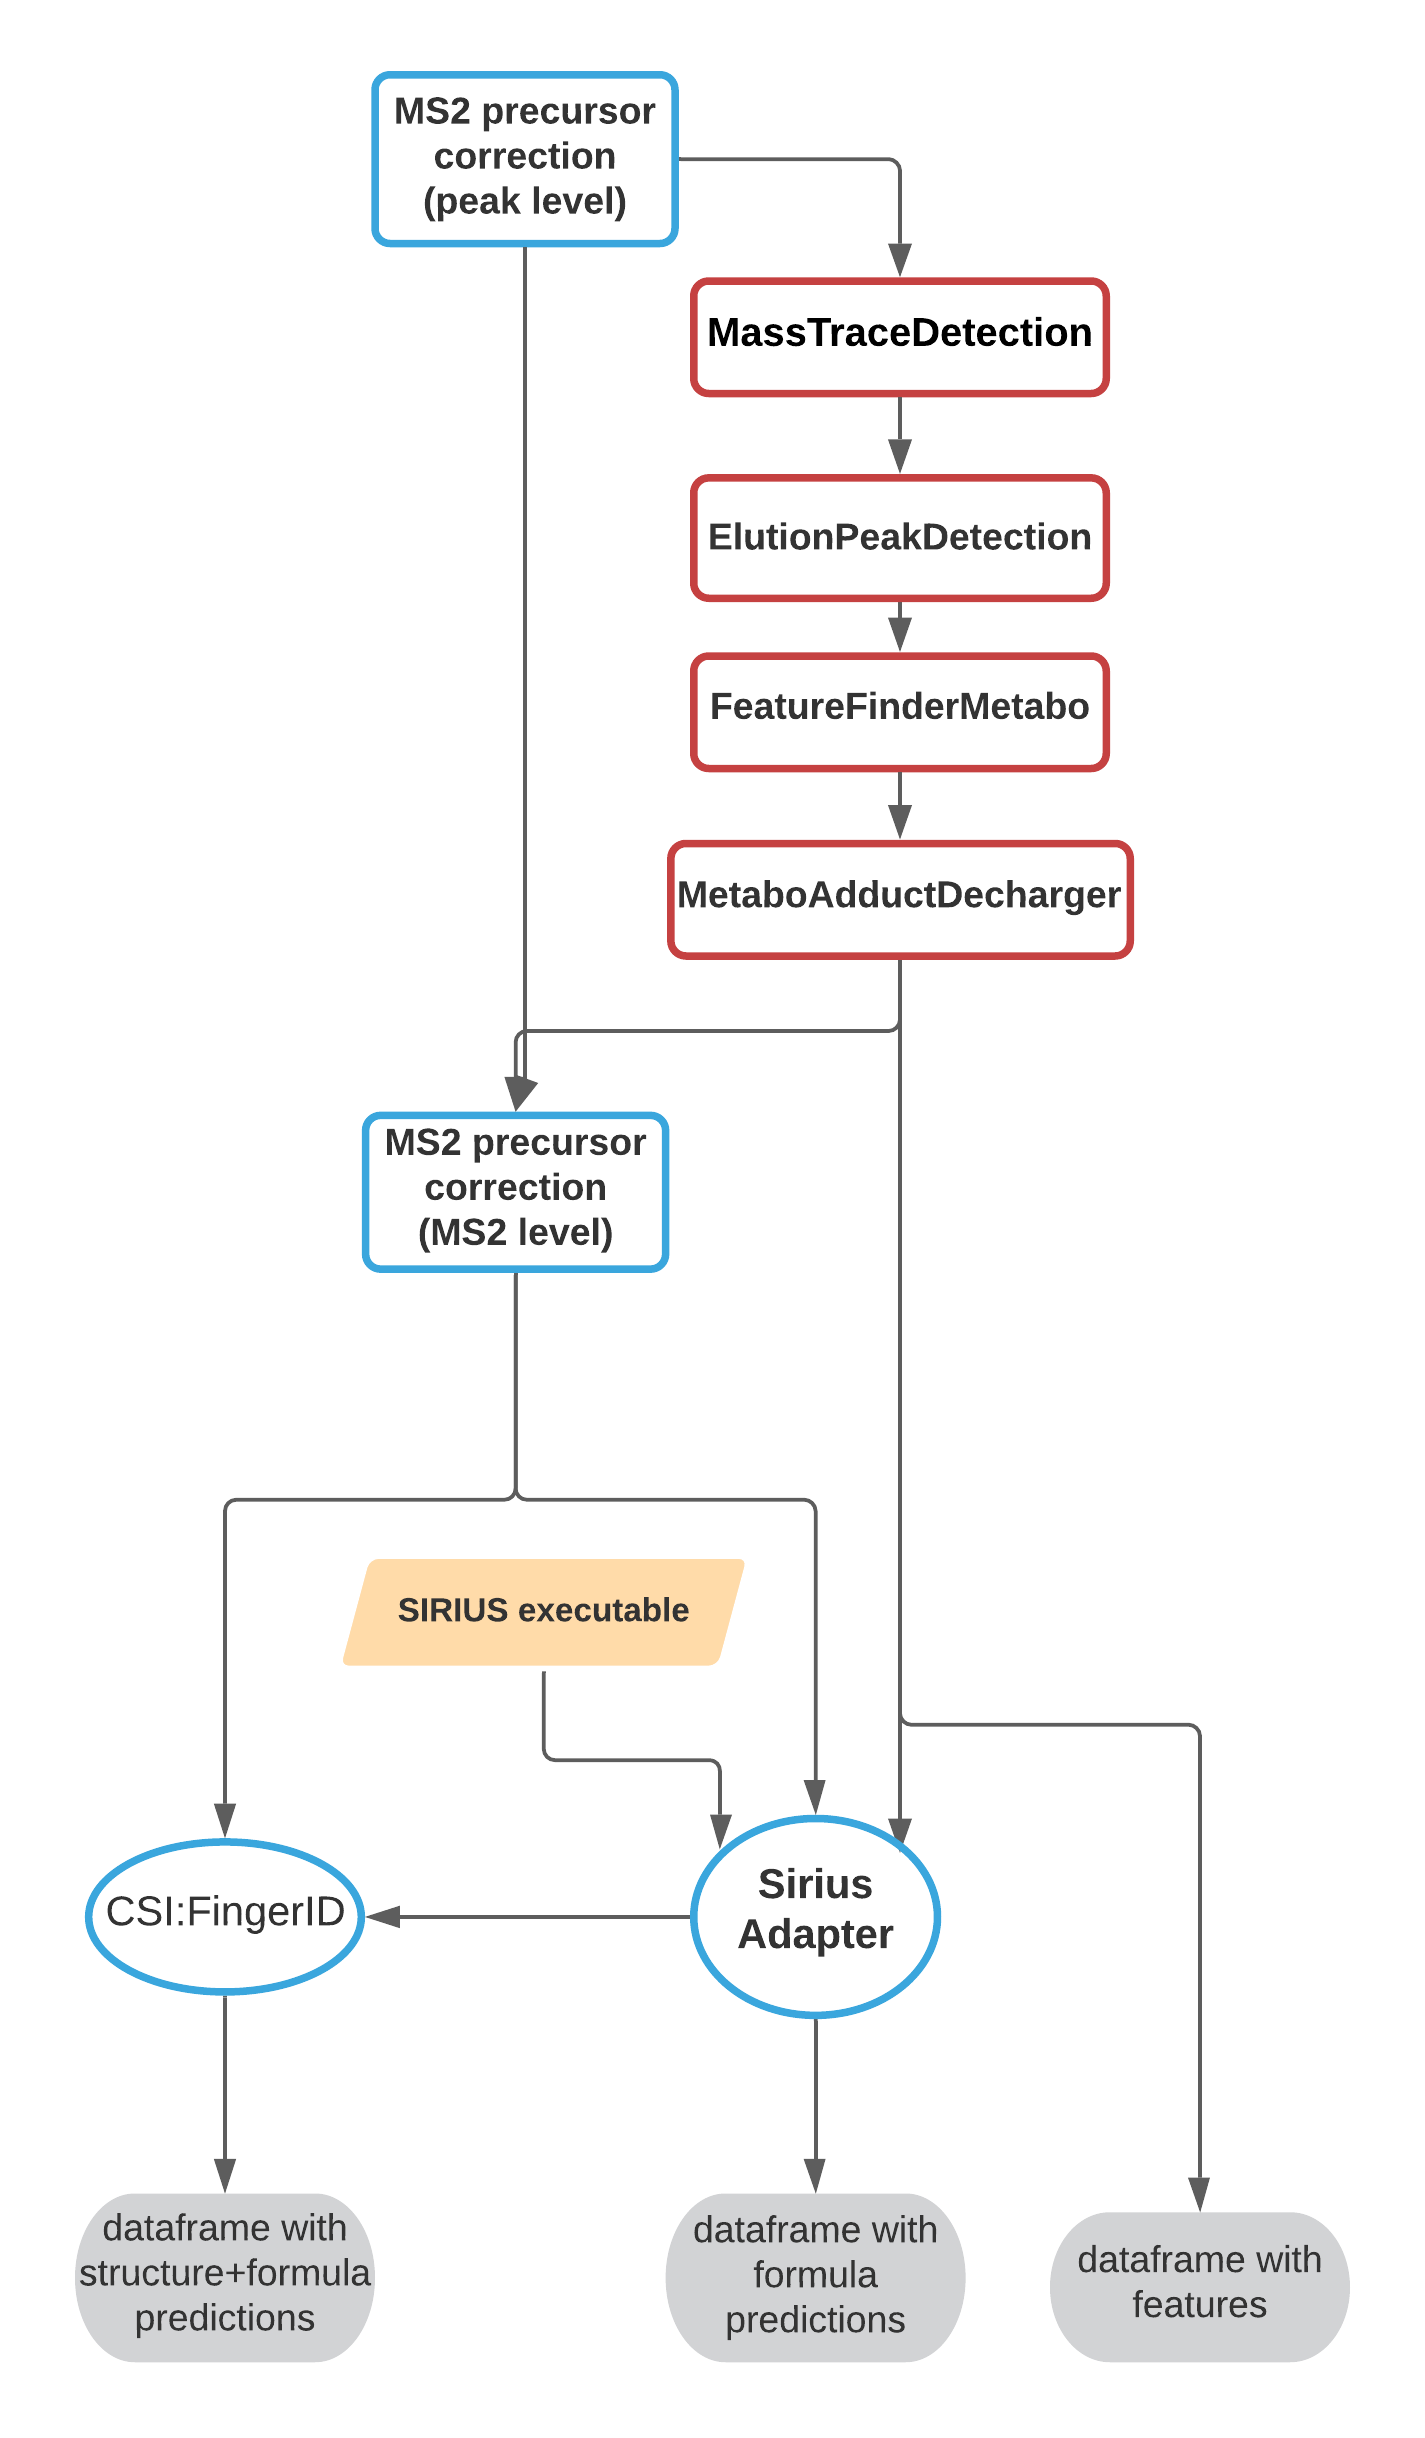

In [ ]:
path = os.path.join("results", "interim", "mzML")
try:
    shutil.rmtree(path)
    os.mkdir(path)
except OSError:
    os.mkdir(path)

input_original_files = glob.glob('data/mzML/*.mzML')
    
for filename in input_original_files:
    exp = MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    delta_mzs= []
    mzs = []
    rts= []
    PrecursorCorrection.correctToHighestIntensityMS1Peak(exp, 100.0, True, delta_mzs, mzs, rts)
    mzmlfile_path = os.path.join(path, 'PCpeak_' + os.path.basename(filename))
    MzMLFile().store(mzmlfile_path, exp)

#### `2) Mass trace detection`

A mass trace extraction method that gathers peaks similar in m/z and moving along retention time.
Peaks of a MSExperiment are sorted by their intensity and stored in a list of potential chromatographic apex positions. Only peaks that are above the noise threshold (user-defined) are analyzed and only peaks that are n times above this minimal threshold are considered as apices. This saves computational resources and decreases the noise in the resulting output.
Starting with these, mass traces are extended in- and decreasingly in retention time. During this extension phase, the centroid m/z is computed on-line as an intensity-weighted mean of peaks.
The extension phase ends when either the frequency of gathered peaks drops below a threshold (min_sample_rate, see MassTraceDetection parameters) or when the number of missed scans exceeds a threshold (trace_termination_outliers, see MassTraceDetection parameters).
Finally, only mass traces that pass a filter (a certain minimal and maximal length as well as having the minimal sample rate criterion fulfilled) get added to the result.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1MassTraceDetection.html#abff6e392ce6da7af8f083397494a7971



#### `3) Elution peak detection`

Extracts chromatographic peaks from a mass trace.
Mass traces may consist of several consecutively (partly overlapping) eluting peaks, e.g., stemming from (almost) isobaric compounds that are separated by retention time. Especially in metabolomics, isomeric compounds with exactly the same mass but different retentional behaviour may still be contained in the same mass trace. This method first applies smoothing on the mass trace's intensities, then detects local minima/maxima in order to separate the chromatographic peaks from each other. Depending on the "width_filtering" parameters, mass traces are filtered by length in seconds ("fixed" filter) or by quantile.

This method is in other words "deconvolution".

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1ElutionPeakDetection.htmldetails


#### `4) Feature detection`

FeatureFinderMetabo assembles metabolite features from singleton mass traces.
Mass traces alone would allow for further analysis such as metabolite ID or statistical evaluation. However, in general, monoisotopic mass traces are accompanied by satellite C13 peaks and thus may render the analysis more difficult. FeatureFinderMetabo fulfills a further data reduction step by assembling compatible mass traces to metabolite features (that is, all mass traces originating from one metabolite). To this end, multiple metabolite hypotheses are formulated and scored according to how well differences in RT (optional), m/z or intensity ratios match to those of theoretical isotope patterns.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1FeatureFindingMetabo.html

#### `5) Metabolite adduct decharger` 

For each peak, this algorithm reconstructs neutral masses by enumerating all possible adducts with matching charge. You can add the list of adduct files and database files for the algorithm to parse through.
With SIRIUS, an algorithm that is later used, you are only able to use singly charged adducts so charges higher than 1 are filtered out. 

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/UTILS_MetaboliteAdductDecharger.html

In [ ]:
path = os.path.join("results", "interim", "preprocess")
try:
    shutil.rmtree(path)
    os.mkdir(path)
except OSError:
    os.mkdir(path)

input_mzml_files = glob.glob('results/interim/mzML/PCpeak_*.mzML')

# 2) Mass trace detection

feature_maps_FFM= []
for filename in input_mzml_files:
    exp = MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    mass_traces = []
    mtd = MassTraceDetection()
    mtd_par = mtd.getDefaults()
    mtd_par.setValue("mass_error_ppm", 10.0) 
    mtd_par.setValue("noise_threshold_int", 1.0e04)
    mtd.setParameters(mtd_par)
    mtd.run(exp, mass_traces, 0)

# 3) Elution peak detection (deconvolution)

    mass_traces_split = []
    mass_traces_final = []
    epd = ElutionPeakDetection()
    epd_par = epd.getDefaults()
    epd_par.setValue("width_filtering", "fixed")
    epd.setParameters(epd_par)
    epd.detectPeaks(mass_traces, mass_traces_split)
     
    if (epd.getParameters().getValue("width_filtering") == "auto"):
          epd.filterByPeakWidth(mass_traces_split, mass_traces_final)
    else:
          mass_traces_final = mass_traces_split

# 4) Feature finding metabo (isotope reduction)
  
    feature_map_FFM = FeatureMap()
    feat_chrom = []
    ffm = FeatureFindingMetabo()
    ffm_par = ffm.getDefaults() 
    ffm_par.setValue("isotope_filtering_model", "none")
    ffm_par.setValue("remove_single_traces", "true")
    ffm_par.setValue("mz_scoring_by_elements", "false")
    ffm_par.setValue("report_convex_hulls", "true")
    ffm.setParameters(ffm_par)
    ffm.run(mass_traces_final, feature_map_FFM, feat_chrom)
    
    feature_map_FFM.setUniqueIds()
    feature_map_FFM.setPrimaryMSRunPath([filename.encode()])  

    feature_map_filtered = FeatureMap(feature_map_FFM)
    feature_map_filtered.clear(False)

    for f in feature_map_FFM:
        if f.getOverallQuality() > 0.0005:
            feature_map_filtered.push_back(f)

    feature_map_FFM = feature_map_filtered

    feature_maps_FFM.append(feature_map_FFM)

# 5) Adduct annotation

    mfd = MetaboliteFeatureDeconvolution()
    mdf_par = mfd.getDefaults()
    mdf_par.setValue("potential_adducts", [b"H:+:0.4",b"Na:+:0.2",b"NH4:+:0.2", b"H-1O-1:+:0.1", b"H-3O-2:+:0.1"])
    mdf_par.setValue("charge_min", 1, "Minimal possible charge")
    mdf_par.setValue("charge_max", 1, "Maximal possible charge")
    mdf_par.setValue("charge_span_max", 1)
    mdf_par.setValue("max_neutrals", 1)
    mfd.setParameters(mdf_par)
        
    feature_map_MFD = FeatureMap()
    cons_map0 = ConsensusMap()
    cons_map1 = ConsensusMap()
    mfd.compute(feature_map_FFM, feature_map_MFD, cons_map0, cons_map1)
    consensusfile = os.path.join(path, 'MFD_' + os.path.basename(filename)[7:-5] +".consensusXML")
    ConsensusXMLFile().store(consensusfile, cons_map0)
    featurefile = os.path.join(path, 'MFD_' + os.path.basename(filename)[7:-5] +".featureXML")
    FeatureXMLFile().store(featurefile, feature_map_MFD)

Display the features in a dataframe

In [ ]:
input_feature_files = sorted(glob.glob('results/interim/preprocess/MFD_*.featureXML'))

for filename in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(filename, fmap)
    DF= fmap.get_df(export_peptide_identifications=False)
    feature_csv= os.path.join("results", "features", 'features_' + os.path.basename(filename)[4:-10] +"csv")
    DF.to_csv(feature_csv)
print("example:", os.path.basename(filename))
display(DF)

#### `6) PrecursorCorrection (To the "nearest feature”)`

This algorithm is used after feature detection and adduct grouping to allow for precursor correction on MS2 level. 

If there are MS2 spectra in the feature space which have been measured in isotope traces, it “corrects” the MS2 spectrum annotation to the monoisotopic trace. 

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1PrecursorCorrection.html

In [8]:
path = os.path.join("results", "interim", "mzML")

input_mzml_files = sorted(glob.glob('results/interim/mzML/PCpeak_*.mzML'))
input_feature_files = sorted(glob.glob('results/interim/preprocess/MFD_*.featureXML'))

for mzml in input_mzml_files:
    exp = MSExperiment()
    MzMLFile().load(mzml, exp)
    exp.sortSpectra(True)
    correct = PrecursorCorrection()

    for filename in input_feature_files:
        feature_map_MFD = FeatureMap()
        FeatureXMLFile().load(filename, feature_map_MFD)
        if os.path.basename(mzml)[7:-5] == os.path.basename(filename)[4:-11]:
            correct.correctToNearestFeature(feature_map_MFD, exp, 0.0, 100.0, True, False, False, False, 3, 0)
            corrected_file = os.path.join(path, 'PCfeature_' + os.path.basename(mzml)[7:])
            MzMLFile().store(corrected_file, exp)

#### `7) MapAlignerPoseClustering `
This algorithm is used to perform a linear retention time alignment, in order to correct for chromatographic shifts in retention time. The reference file used for Map Alignment is the feature map with the highest number of features.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_MapAlignerPoseClustering.html

In [ ]:
path = os.path.join("results", "interim", "preprocess")

input_feature_files = sorted(glob.glob('results/interim/preprocess/MFD_*.featureXML'))
feature_maps=[]
for filename in input_feature_files:
    feature_map_MFD = FeatureMap()
    FeatureXMLFile().load(filename, feature_map_MFD)
    feature_maps.append(feature_map_MFD)

ref_index = [i[0] for i in sorted(enumerate([fm.size() for fm in feature_maps]), key=lambda x:x[1])][-1]

aligner = MapAlignmentAlgorithmPoseClustering()
aligner_par= aligner.getDefaults()

aligner_par.setValue("max_num_peaks_considered", -1)
aligner_par.setValue("superimposer:mz_pair_max_distance", 0.05)
aligner_par.setValue("pairfinder:distance_MZ:max_difference", 10.0)
aligner_par.setValue("pairfinder:distance_MZ:unit", "ppm")
aligner.setParameters(aligner_par)
aligner.setReference(feature_maps[ref_index])

for feature_map in feature_maps[:ref_index] + feature_maps[ref_index+1:]:
    trafo = TransformationDescription()
    aligner.align(feature_map, trafo)
    transformer = MapAlignmentTransformer()
    transformer.transformRetentionTimes(feature_map, trafo, True) # store original RT as meta value

for feature_map in feature_maps:    
    feature_file = os.path.join(path, 'MapAligned_' + os.path.basename(feature_map.getMetaValue('spectra_data')[0].decode())[7:-5] +".featureXML")
    trafo_file= os.path.join(path, 'MapAligned_' + os.path.basename(feature_map.getMetaValue('spectra_data')[0].decode())[7:-5] +".trafoXML")
    FeatureXMLFile().store(feature_file, feature_map)
    TransformationXMLFile().store(trafo_file, trafo)

Visualisation of data before and after alignment:

/var/folders/c_/ysz9v_bd1yb7h3ymmkn6m199jbv7x7/T/ipykernel_73132/3299292427.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


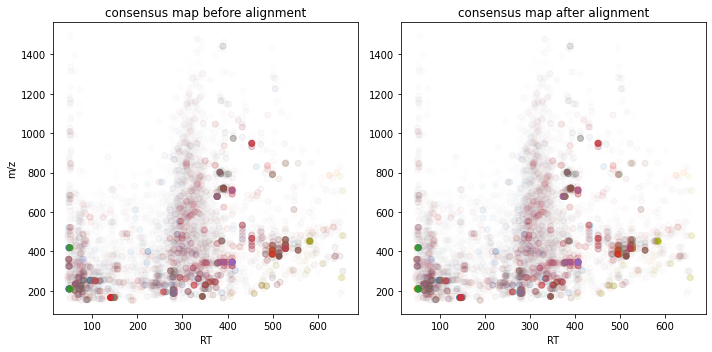

In [10]:
import matplotlib.pyplot as plt
import numpy as np

feature_maps = [feature_maps[ref_index]] + feature_maps[:ref_index] + feature_maps[ref_index+1:]

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1, 2, 1)
ax.set_title('consensus map before alignment')
ax.set_ylabel('m/z')
ax.set_xlabel('RT')

# use alpha value to display feature intensity
ax.scatter([f.getRT() for f in feature_maps[0]], [f.getMZ() for f in feature_maps[0]],
            alpha = np.asarray([f.getIntensity() for f in feature_maps[0]])/max([f.getIntensity() for f in feature_maps[0]]))

for fm in feature_maps[1:]:
    ax.scatter([f.getMetaValue('original_RT') for f in fm], [f.getMZ() for f in fm],
                alpha = np.asarray([f.getIntensity() for f in fm])/max([f.getIntensity() for f in fm]))

ax = fig.add_subplot(1,2,2)
ax.set_title('consensus map after alignment')
ax.set_xlabel('RT')

for fm in feature_maps:
    ax.scatter([f.getRT() for f in fm], [f.getMZ() for f in fm],
                alpha = np.asarray([f.getIntensity() for f in fm])/max([f.getIntensity() for f in fm]))

fig.tight_layout()
#fig.legend([fmap.getDataProcessing()[0].getMetaValue('parameter: out')[:-11] for fmap in feature_maps], loc = 'lower center')
fig.show()

#### `8) FeatureGroupingAlgorithmKD `

Feature linker clusters the feature information (from single files) into a ConsensusFeature, linking features from different files together, which have a smiliar m/z and rt (no MS2 data).

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_FeatureLinkerUnlabeledKD.html

In [13]:
input_feature_files = sorted(glob.glob('results/interim/preprocess/*.featureXML'))

feature_maps = []
for featurexml_file in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(featurexml_file, fmap)
    feature_maps.append(fmap)

In [14]:
feature_grouper = FeatureGroupingAlgorithmKD()

consensus_map = ConsensusMap()
file_descriptions = consensus_map.getColumnHeaders()

for i, feature_map in enumerate(feature_maps):
    file_description = file_descriptions.get(i, ColumnHeader())
    file_description.filename = os.path.basename(feature_map.getMetaValue('spectra_data')[0].decode())[7:]
    file_description.size = feature_map.size()
    file_descriptions[i] = file_description

feature_grouper.group(feature_maps, consensus_map)
consensus_map.setColumnHeaders(file_descriptions)


Consensus_file= os.path.join(path, 'consensus' + ".consensusXML")
ConsensusXMLFile().store(Consensus_file, consensus_map)


# get intensities as a DataFrame
result = consensus_map.get_df()
result= result.reset_index()
result= result.drop(columns= ["sequence"])
# store as tsv file
result.to_csv('results/features/FeatureMatrix.tsv', sep = '\t', index = False)
result

Progress of 'computing RT transformations':
-- done [took 0.11 s (CPU), 0.12 s (Wall)] -- 
Progress of 'linking features':
-- done [took 0.25 s (CPU), 0.25 s (Wall)] -- 
ConsensusXMLFile::store():  found 9106 invalid unique ids


,charge,RT,mz,20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.mzML,20211009_UMETAB222_POS_33_FPY12_Plate-13_NBC_01134_rep3.mzML,20211009_UMETAB222_POS_12_FPY12_Plate-13_NBC_01116_rep1.mzML,20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep1.mzML,20211009_UMETAB222_POS_31_ISP2_Plate-13_NBC_01134_rep3.mzML,20211009_UMETAB222_POS_32_DNPM_Plate-13_NBC_01134_rep3.mzML,20211009_UMETAB222_POS_10_ISP2_Plate-13_NBC_01116_rep1.mzML,20211009_UMETAB222_POS_11_DNPM_Plate-13_NBC_01116_rep1.mzML,20211009_UMETAB222_POS_22_ISP2_Plate-13_NBC_01116_rep2.mzML,20211009_UMETAB222_POS_24_FPY12_Plate-13_NBC_01116_rep2.mzML,20211006_UMETAB222_POS_28_ISP2_Plate-11_NBC_00843_rep3.mzML,20211009_UMETAB222_POS_23_DNPM_Plate-13_NBC_01116_rep2.mzML
0,1,473.883300,228.195786,7.158484e+06,8.223848e+06,7479438.0,5396077.0,6456007.0,7490720.0,6276594.0,6472127.0,6254406.0,8604468.0,1.347532e+07,6877668.0
1,1,637.147984,388.263562,6.821783e+05,1.727871e+06,0.0,1901299.0,1488465.0,1692647.0,1297476.0,1449316.0,1599266.0,1967858.0,4.669828e+05,1948491.0
2,1,78.825287,185.092057,6.814153e+06,1.585855e+06,0.0,8052714.0,9785494.0,18193690.0,11802700.0,20620940.0,5129649.0,3993600.0,9.691823e+06,19825910.0
3,1,100.224040,195.112804,5.361819e+06,3.385145e+06,0.0,3564171.0,10770410.0,25457100.0,12812270.0,26797860.0,7030839.0,4120325.0,7.435392e+06,28316300.0
4,1,634.974247,376.263502,5.051651e+06,1.334391e+07,0.0,16889030.0,11390910.0,14372010.0,11274350.0,12148810.0,12087870.0,16178760.0,3.930575e+06,15677730.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,1,397.147549,297.180912,0.000000e+00,1.093783e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0
9101,2,309.704904,1221.065227,0.000000e+00,5.275976e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0
9102,2,305.437594,718.854969,0.000000e+00,2.325723e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0
9103,2,291.681313,640.804512,0.000000e+00,1.640561e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0


#### `9) MapAlignmentTransformer`
This algorithm is used to perform a linear retention time alignment, in order to correct for chromatographic shifts in retention time. Use the trafo XML files from the feature alignment and align the raw spectra.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1MapAlignmentTransformer.html

In [ ]:
path= "results/interim/Requant"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

input_mzml_files = sorted(glob.glob('results/interim/mzML/PCpeak_*.mzML'))
input_trafo = sorted(glob.glob('results/interim/preprocess/*.trafoXML'))

for filename in input_mzml_files:
    exp= MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    transformer = MapAlignmentTransformer()

    for trafo_XML in input_trafo:
        trafo=TransformationDescription()
        TransformationXMLFile().load(trafo_XML, trafo, True)
        if os.path.basename(trafo_XML)[11:-9] == os.path.basename(filename)[7:-5]:
            transformer.transformRetentionTimes(exp, trafo, True)
            mzml_file = os.path.join(path, 'MapAligned_' + os.path.basename(exp.getLoadedFilePath())[7:-5] +".mzML")
            MzMLFile().store(mzml_file, exp)

#### `10) FeatureFinderMetaboIdent`
This algorithm detects and extracts MS1 data that match the feature list in the metabolite identification table.

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/UTILS_FeatureFinderMetaboIdent.html

In [ ]:
#Import the consensus tsv table and keep only the columns: RT, mz and charge
DF_features = pd.read_csv("results/features/FeatureMatrix.tsv", sep="\t")
DF_features = DF_features[['RT','mz', "charge"]]

#convert the mz and RT columns to floats and charge to integer for calculations
DF_features["charge"] = pd.to_numeric(DF_features["charge"], downcast="integer")
DF_features["mz"] = pd.to_numeric(DF_features["mz"], downcast="float")
DF_features["RT"] = pd.to_numeric(DF_features["RT"], downcast="float")

#Add a columns named "Mass" and calculate the neutral masses from the charge and mz:
DF_features["Mass"]= 0.0
for ind in DF_features.index:
    if DF_features["charge"][ind] == 0:
        DF_features.loc[ind, "Mass"]= DF_features.loc[ind,"mz"]
    if DF_features["charge"][ind] == 1:
        DF_features.loc[ind, "Mass"]= DF_features.loc[ind,"mz"]- 1.007825
    if DF_features["charge"][ind] == 2:
        DF_features.loc[ind, "Mass"]= (DF_features.loc[ind,"mz"]*2)- 2.015650
    if DF_features["charge"][ind] == 3:
        DF_features.loc[ind, "Mass"]= (DF_features.loc[ind,"mz"]*3)- 3.023475

#Rename columns to the required ones and add positive or negative sign for charge
DF_features= DF_features.rename(columns={"RT": "RetentionTime", "charge":"Charge"})
DF_features["Charge"]= DF_features["Charge"].astype(str)
for ind in DF_features.index:
    if DF_features["Charge"][ind] == "1":
        DF_features.loc[ind, "Charge"]= "+" + DF_features.loc[ind,"Charge"]
    if DF_features["Charge"][ind] == "2":
        DF_features.loc[ind, "Charge"]= "+" + DF_features.loc[ind,"Charge"]
    if DF_features["Charge"][ind] == "3":
        DF_features.loc[ind, "Charge"]= "+" + DF_features.loc[ind,"Charge"]
#drop the mz column
DF_features= DF_features.drop(columns= "mz")

#add the rest of the columns required for the MetaboliteIdentificationTable and fill with zeros or blanks, except the "Compound Name"
#which, since they are all unknown, can be filled with feature_#
DF_features['CompoundName'] = np.arange(len(DF_features))
DF_features['CompoundName'] = "feature_" + DF_features['CompoundName'].astype(str)
DF_features["SumFormula"] = " "
DF_features["RetentionTimeRange"]= "0"
DF_features["IsoDistribution"]= "0"
DF_features= DF_features[["CompoundName","SumFormula", "Mass","Charge","RetentionTime","RetentionTimeRange", "IsoDistribution"]]
DF_features.to_csv("resources/MetaboliteIdentification.tsv", sep="\t", index= None)
DF_features

In [ ]:
import csv
# read tsv file and create list of FeatureFinderMetaboIdentCompound
def metaboTableFromFile(path_to_library_file):
    metaboTable = []
    with open(path_to_library_file, 'r') as tsv_file:
        tsv_reader = csv.reader(tsv_file, delimiter="\t")
        next(tsv_reader) # skip header
        for row in tsv_reader:
            metaboTable.append(FeatureFinderMetaboIdentCompound(
                row[0], # name
                row[1], # sum formula
                float(row[2]), # mass
                [int(charge) for charge in row[3].split(',')], # charges
                [float(rt) for rt in row[4].split(',')], # RTs
                [float(rt_range) for rt_range in row[5].split(',')], # RT ranges
                [float(iso_distrib) for iso_distrib in row[6].split(',')] # isotope distributions
            ))
    return metaboTable

In [ ]:
input_mzml_files=sorted(glob.glob("results/interim/Requant/*.mzML"))
path = "results/interim/Requant"
# load ms data from mzML file into MSExperiment
for mzml_file in input_mzml_files:
    spectra = MSExperiment()
    MzMLFile().load(mzml_file, spectra)

    # create FeatureFinderAlgorithmMetaboIdent and assign ms data
    ff = FeatureFinderAlgorithmMetaboIdent()
    ff.setMSData(spectra)

    # read library generate a metabo table with compounds
    metabo_table = metaboTableFromFile('resources/MetaboliteIdentification.tsv')

    params = ff.getParameters()
    params[b'extract:mz_window'] = 5.0 
    params[b'detect:peak_width'] = 20.0  #adjust for wide peaks
    ff.setParameters(params)
    # FeatureMap to store results
    fm = FeatureMap()
    # run the FeatureFinderMetaboIdent with the metabo_table and store results in fm
    ff.run(metabo_table, fm, String(mzml_file))

    # save FeatureMap to file
    ff_file = os.path.join(path, 'FFMI_' + os.path.basename(mzml_file)[11:-5] +".featureXML")
    FeatureXMLFile().store(ff_file, fm)

Compare the preprocessed to the requantified:

In [ ]:
Preprocessed= glob.glob("results/features/*.csv")
Requantified= glob.glob("results/Requant/*.csv")

for table in Preprocessed:
    df1= pd.read_csv(table)
    feature_no= len(df1)

    for matrix in Requantified:
        df2= pd.read_csv(matrix)
        requant_no= len(df2)

        if os.path.basename(table)== os.path.basename(matrix):
            print(os.path.basename(matrix))
            print("Preprocessed:", feature_no, "Requantified:", requant_no)
   

#### `11) FeatureGroupingAlgorithmKD `

Feature linker clusters the feature information (from single files) into a ConsensusFeature, linking features from different files together, which have a smiliar m/z and rt (no MS2 data).

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_FeatureLinkerUnlabeledKD.html

In [ ]:
input_feature_files = sorted(glob.glob('results/interim/Requant/FFMID_*.featureXML'))

feature_maps = []
for featurexml_file in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(featurexml_file, fmap)
    feature_maps.append(fmap)

In [ ]:
feature_grouper = FeatureGroupingAlgorithmKD()

consensus_map = ConsensusMap()
file_descriptions = consensus_map.getColumnHeaders()

for i, feature_map in enumerate(feature_maps):
    file_description = file_descriptions.get(i, ColumnHeader())
    file_description.filename = os.path.basename(feature_map.getMetaValue('spectra_data')[0].decode())[7:]
    file_description.size = feature_map.size()
    file_descriptions[i] = file_description

feature_grouper.group(feature_maps, consensus_map)
consensus_map.setColumnHeaders(file_descriptions)


Consensus_file= os.path.join(path, 'consensus' + ".consensusXML")
ConsensusXMLFile().store(Consensus_file, consensus_map)


# get intensities as a DataFrame
result = consensus_map.get_df()
result= result.reset_index()
result= result.drop(columns= ["sequence"])
# store as tsv file
result.to_csv('results/Requant/FeatureMatrix.tsv', sep = '\t', index = False)
result